<h1>WSDM - KKBox's Music Recommendation Challenge Exploratory Data Analysis</h1>

#### *A brief overview of the Exploratory Data Analysis can be found at https://share.streamlit.io/learner-subodh/streamlit-example/kkbox.py*

<h2>1. Business Problem</h2>

<h3>1.1 Problem Description</h3>

The 11th ACM International Conference on Web Search and Data Mining (WSDM 2018) challenged to build a better music recommendation system using a donated dataset from KKBOX. WSDM (pronounced "wisdom") is one of the premier conferences on web inspired research involving search and data mining.

The glory days of Radio DJs have passed, and musical gatekeepers have been replaced with personalizing algorithms and unlimited streaming services. With easy access to various kinds of music across the globe, public is now listening to all kinds of music. Existing algorithms, however, struggle in key areas. Without enough historical data, how would an algorithm know if listeners will like a new song or a new artist? And how would it know what songs to recommend brand new users?

The dataset is from KKBOX, Asia’s leading music streaming service, holding the world’s most comprehensive Asia-Pop music library with over 30 million tracks. The input contains text data only, and no audio features.  They currently use a collaborative filtering based algorithm with matrix factorization and word embedding in their recommendation system but believe new techniques could lead to better results.

In this case study, we will be looking towards some good techniques to recommend music to brand new as well as existing users. By building this system, we aim to provide a better user experience for the app users.

<h3>1.2 Problem Statement</h3>

We are asked to predict the chances of a user listening to a song repetitively after the first observable listening event within a time window was triggered.  The objective is to make prediction on whether a user will re-listen to a song or not. Broadly, it is a music recommendation problem. (ROC-AUC Score as per Kaggle Challenge Evaluation Metric)

<h3>1.3 Sources/References</h3>

1. Paper: KKBox’s Music Recommendation, Yunru Huang, Mengyu Li, Yun Wu, Stanford University: http://cs229.stanford.edu/proj2019spr/report/4.pdf

2. Paper: KKBOX’s Music Recommendation Challenge Solution with Feature Engineering, Jianyu Zhang, Françoise Fogelman-Soulié, School of Computer Software, Tianjin University: https://wsdm-cup-2018.kkbox.events/pdf/WSDM_KKboxs_Music_Recommendation_Challenge_6th_Solution.pdf

3. Kaggle Notebook: Recommendation System with 83% accuracy lgbm: https://www.kaggle.com/rohandx1996/recommendation-system-with-83-accuracy-lgbm

4. Kaggle Notebook: Introduction to Boosting using LGBM (LB: 0.68357): https://www.kaggle.com/vinnsvinay/introduction-to-boosting-using-lgbm-lb-0-68357

5. Blog: WSDM — KKBox’s Music Recommendation Challenge: https://medium.com/@anjar.aquil123/wsdm-kkboxs-music-recommendation-challenge-87ca72c41593

<h2>2. Machine Learning Problem</h2>

<h3>2.1 Data</h3>

<h4>Data Overview</h4>

Get the data from: https://www.kaggle.com/c/kkbox-music-recommendation-challenge/data

Data files:

1. members.csv

2. sample_submission.csv

3. song_extra_info.csv

4. songs.csv

5. test.csv

6. train.csv

<h3>2.2 Mapping the real world problem to a Machine Learning Problem</h3>

<h4>2.2.1 Type of Machine Learning Problem</h4>

We are asked to predict the chances of a user listening to a song repetitively after the first observable listening event within a time window was triggered. The objective is to make prediction on whether a user will re-listen to a song or not. Broadly, it is a music recommendation problem.

This can be also thought of as classification problem, that is, whether user will or will not listen to the recommended song.

<h3>2.2.2 Performance metric</h3>

Area under the ROC curve between the predicted probability and the observed target:
https://en.wikipedia.org/wiki/Receiver_operating_characteristic

https://www.analyticsvidhya.com/blog/2020/06/auc-roc-curve-machine-learning/

<h3>2.2.3 Machine Learning Objective and Constraints</h3>

1. Maximize Area Under Curve
2. Try to provide some interpretability

<h2>3. Exploratory Data Analysis</h2>

<h3>3.1 Load the data</h3>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
%cd /content/gdrive/My Drive/Kaggle_KKBoxMusic

/content/gdrive/My Drive/Kaggle_KKBoxMusic


In [ ]:
!pwd

/content/gdrive/My Drive/Kaggle_KKBoxMusic


In [ ]:
import os
os.getcwd()

'/content/gdrive/My Drive/Kaggle_KKBoxMusic'

In [ ]:
!ls

kaggle.json  sample_submission.csv.7z  songs.csv  train.csv
members.csv  song_extra_info.csv       test.csv


*So we now have our required csv files...*

In [ ]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import missingno as msno    #https://github.com/ResidentMario/missingno
#from summary_fn import *

*Creating dataframes*

In [ ]:
# Import csv files & construct dataframes
train = pd.read_csv('train.csv')
members = pd.read_csv('members.csv')
songs = pd.read_csv('songs.csv')
song_extra_info = pd.read_csv('song_extra_info.csv')
test = pd.read_csv('test.csv')

So now we have 5 dataframes:
1. train
2. members
3. songs
4. song_extra_info
5. test

Let's look at some of the functions that we will be using.

In [ ]:
def count_plot(data, x, hue, mytype):
    '''Function to plot Histogram with respect to given arguments'''
    
    plt.figure(figsize=(15, 10))
    sns.set(font_scale=1)
    sns.countplot(x=x, hue=hue, data=data, palette=None)
    plt.xlabel(x, fontsize=20)
    plt.ylabel('Count', fontsize=20)
    plt.xticks(rotation='90')
    if x == hue:
        plt.title('Count Plot for {0} in the {1} data'.format(x, mytype), fontsize=25)
    else:
        plt.title('Count Plot for {0} versus {1} in the {2} data'.format(x, hue, mytype), fontsize=25)
    plt.tight_layout()

In [ ]:
def plot_pdf_cdf(x, flag):
    '''Function to plot PDF and CDF'''
    
    plt.figure(figsize = (15, 10)) 
    kwargs = {'cumulative': True}
    # flag = True implies Plot CDF
    if flag:
        sns.distplot(x, hist_kws=kwargs, kde_kws=kwargs)
        plt.title('CDF for {}'.format(x))
    # flag = False implies Plot PDF
    else:
        sns.distplot(x)
        plt.title('PDF for {}'.format(x))
    sns.set(font_scale=2)

In [ ]:
def calc_percentiles(df, attr, start, stop, step_size):
    '''Function to calculate parecentiles in a given range'''
    ##start: start percentile range from
    ##stop: stop percentile range at
    ##step_size: calculate percentiles at each interval of step size
    for i in range(start, stop, step_size):
        print(f'{i} th percentile value of given attribute is {np.percentile(df[attr], i)}')

<h3>3.2 Explore Train Data<h3>

In [ ]:
train.shape

(7377418, 6)

Thus, we have a total of 7377418 rows/entries and 6 columns in the dataframe. Details about columns are as follows.

In [ ]:
train.columns

Index(['msno', 'song_id', 'source_system_tab', 'source_screen_name',
       'source_type', 'target'],
      dtype='object')

In [ ]:
train.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7377418 entries, 0 to 7377417
Data columns (total 6 columns):
 #   Column              Dtype 
---  ------              ----- 
 0   msno                object
 1   song_id             object
 2   source_system_tab   object
 3   source_screen_name  object
 4   source_type         object
 5   target              int64 
dtypes: int64(1), object(5)
memory usage: 337.7+ MB


msno: user id

song_id: song id

source_system_tab: the name of the tab where the event was triggered. System tabs are used to categorize KKBOX mobile apps functions. For example, tab my library contains functions to manipulate the local storage, and tab search contains functions relating to search.

source_screen_name: name of the layout a user sees.

source_type: an entry point a user first plays music on mobile apps. An entry point could be album, online-playlist, song .. etc.

target: this is the target variable. target=1 means there are recurring listening event(s) triggered within a month after the user’s very first observable listening event, target=0 otherwise .

In [ ]:
train.describe()

,target
count,7.377418e+06
mean,5.035171e-01
std,4.999877e-01
min,0.000000e+00
25%,0.000000e+00
50%,1.000000e+00
75%,1.000000e+00
max,1.000000e+00


In [ ]:
train.isnull().sum(axis = 0)

msno                       0
song_id                    0
source_system_tab      24849
source_screen_name    414804
source_type            21539
target                     0
dtype: int64

Thus, we can observe that source_screen_name hsa most number of null values followed by source_screen_tab and source_type while there aren't any null values in other columns.

In [ ]:
print("Mean of 'target': ", np.mean(train.target))

Mean of 'target':  0.5035170841614234


Thus, data is balanced around the 'target' attribute, which is our label/target variable.

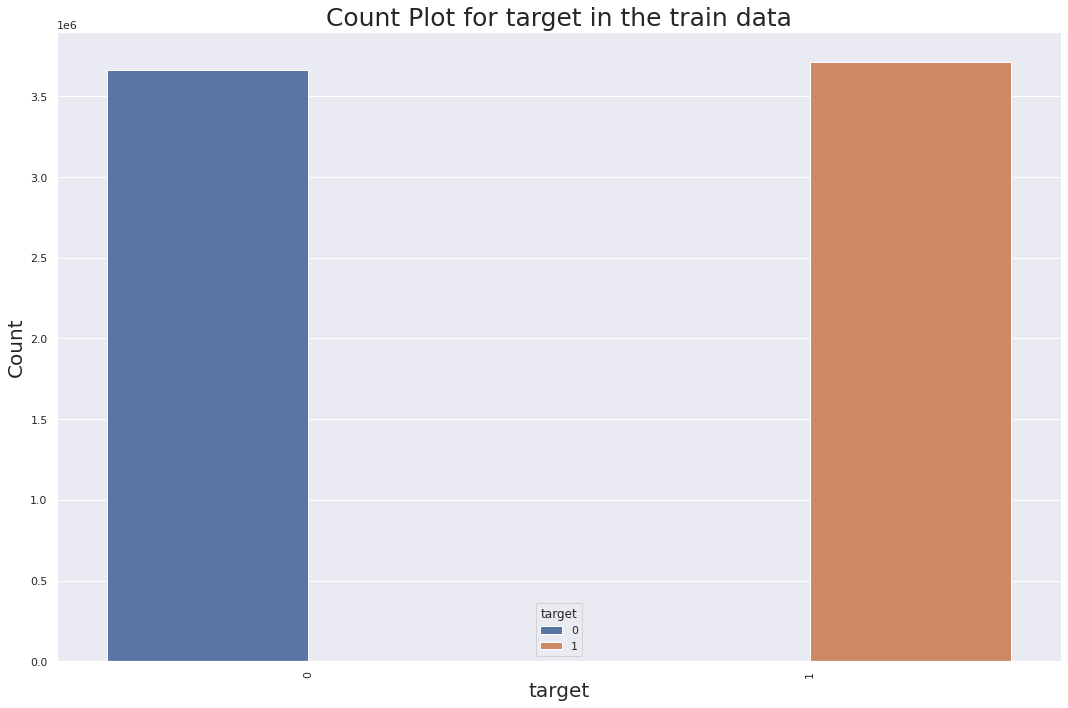

In [ ]:
count_plot(train, 'target', 'target', 'train')

Thus, we can see that the dataset is balanced around the 'target' attribute, as seen previously.

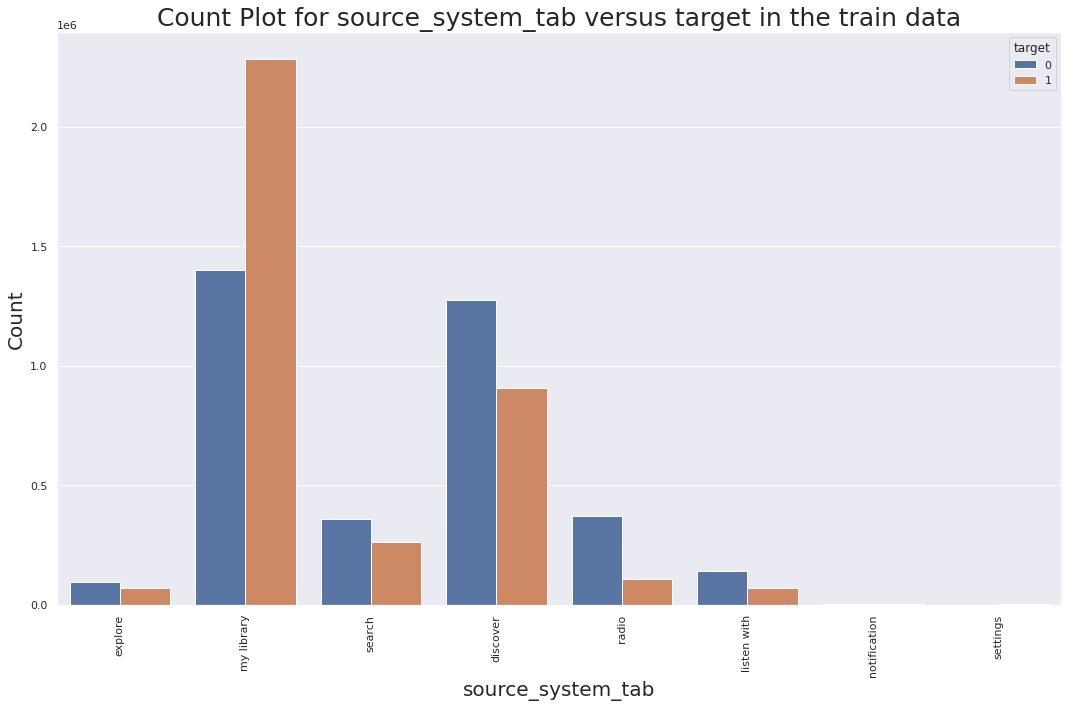

In [ ]:
count_plot(train, 'source_system_tab', 'target', 'train')

As seen previously, 'my library' tab contributes the most to the numbers of events, both with target = 1 as well as target = 0. Also, more number of events, around 60% have a target of 1. This tab is followed by 'discover' tab which has events with target = 0 slightly more than target = 1.

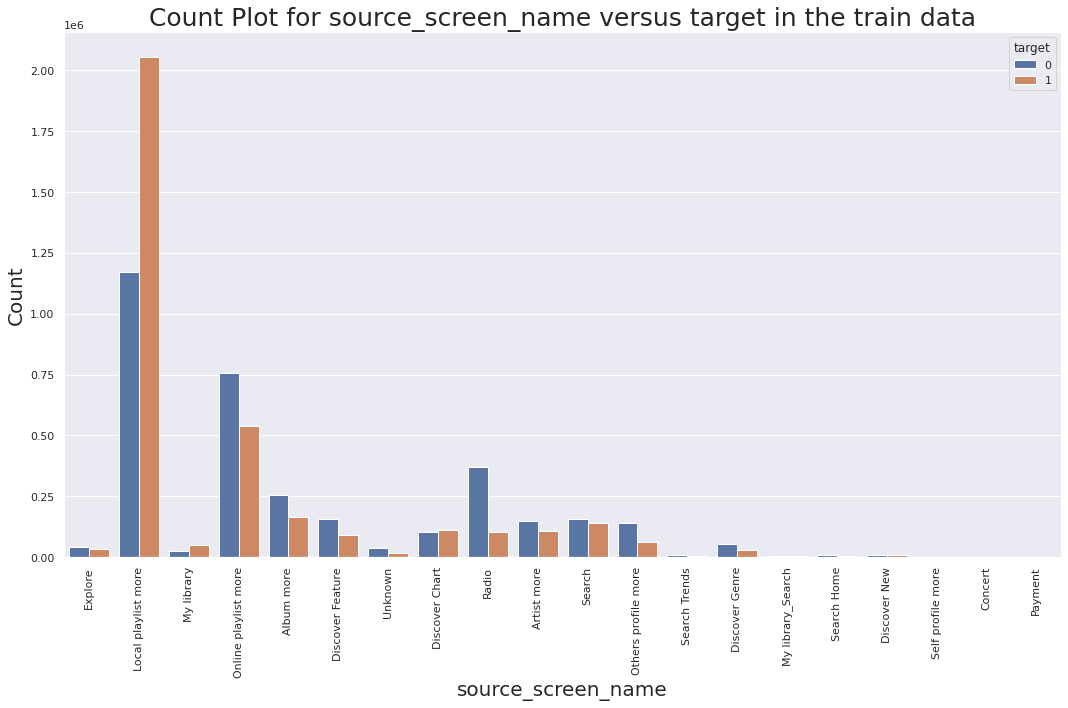

In [ ]:
count_plot(train, 'source_screen_name', 'target', 'train')

Out of the total events generated from 'local playlist more' screen, around two third of them have target = 1 and rest have target = 0. 'online playlist more' also has a good enough contribution towards target = 1 events.

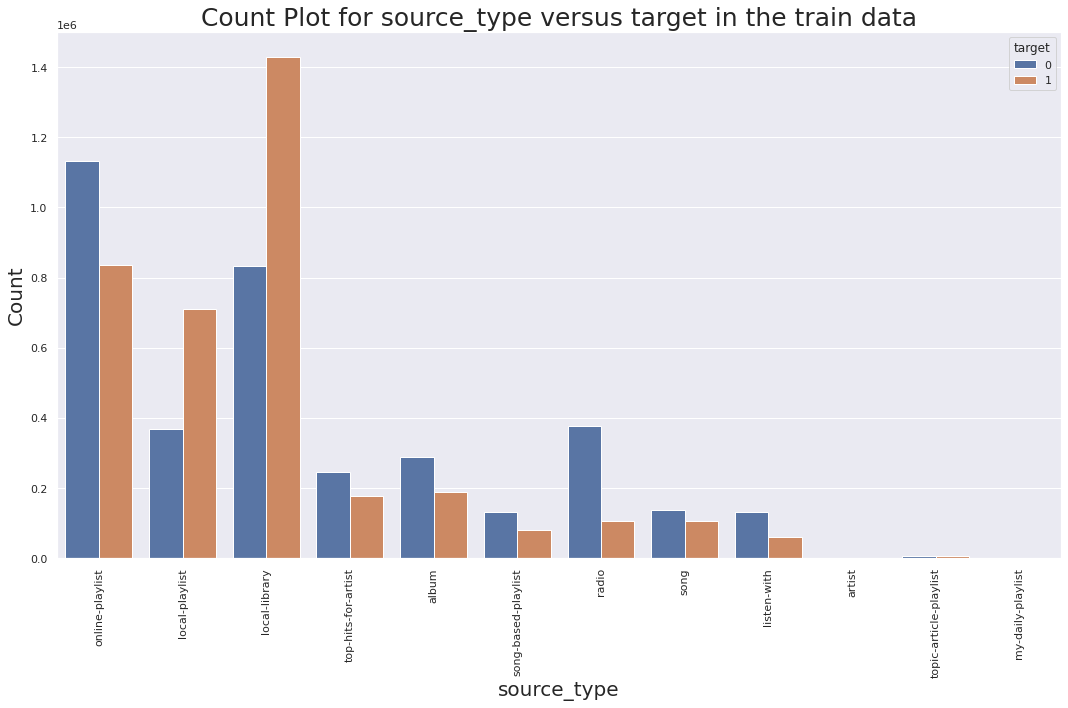

In [ ]:
count_plot(train, 'source_type', 'target', 'train')

The source type 'local library' generates most number of events out of which around two third of the events have target = 1. This source type is followed by 'online playlist' and 'local playlist' which have more contributions towards target = 0 than target = 1.

      Source Screen Name    Target
0                Payment  0.666667
1             My library  0.657173
2    Local playlist more  0.636983
3      My library_Search  0.611223
4         Discover Chart  0.517032
5                Concert  0.510638
6                 Search  0.471749
7           Discover New  0.455531
8                Explore  0.448149
9      Self profile more  0.424528
10           Artist more  0.416858
11  Online playlist more  0.414939
12            Album more  0.390553
13         Search Trends  0.376981
14      Discover Feature  0.364104
15           Search Home  0.353583
16        Discover Genre  0.347887
17               Unknown  0.339155
18   Others profile more  0.312629
19                 Radio  0.217256


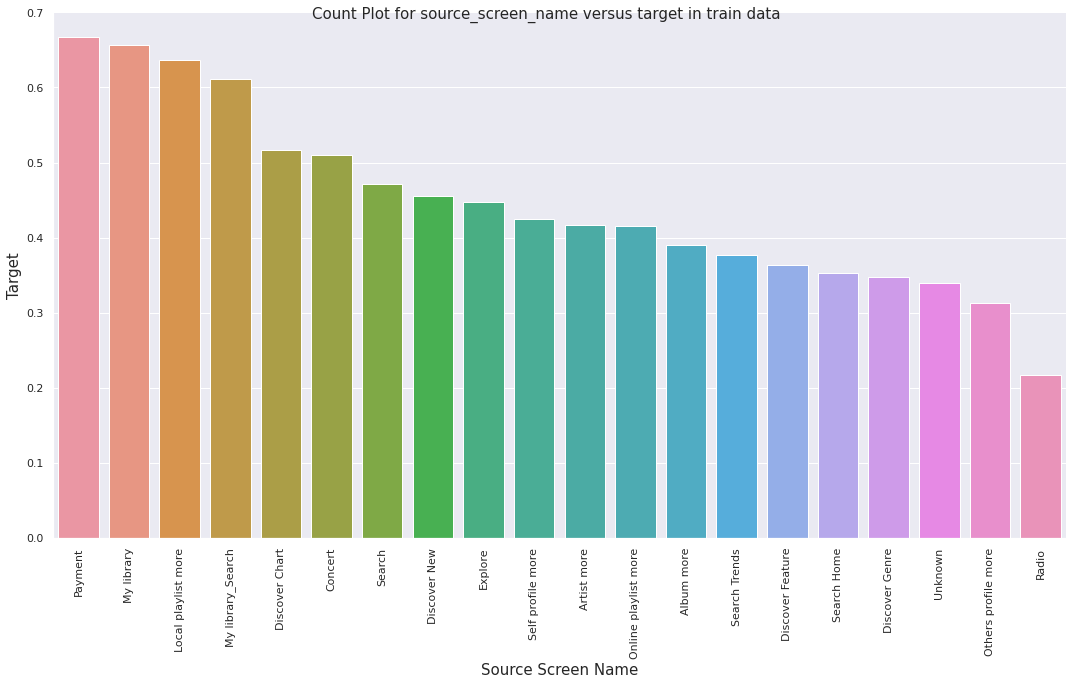

In [ ]:
name = train.groupby(['source_screen_name']).mean().sort_values(by='target', ascending=False)
name.reset_index(level=0, inplace=True)
name.columns = ['Source Screen Name', 'Target']
print(name)
plt.rcParams["axes.labelsize"] = 15     # https://matplotlib.org/3.1.1/tutorials/introductory/customizing.html
                                        # https://stackoverflow.com/questions/37728087/rc-params-in-matplotlib-what-does-rc-stand-for
ax = sns.catplot(x='Source Screen Name', y='Target', kind='bar', palette=None,
                 data=name, height=8, aspect=1.85)
ax.fig.suptitle('Count Plot for source_screen_name versus target in train data', fontsize=15)
for ax in ax.axes.flat:
    plt.setp(ax.get_xticklabels(), rotation=90)

Here we can observe that screens 'payment', 'my library', 'local playlist more' and 'my library search' account for the highest number of events trigerred with target = 1, considerably more than rest of the screens, while 'radio' acreen contributes the least. 

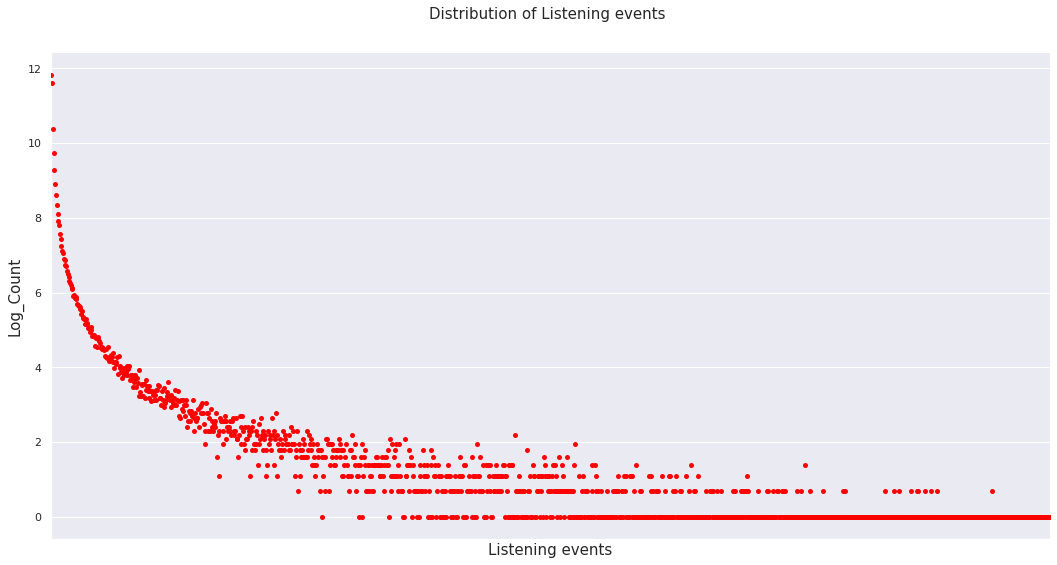

In [ ]:
list_songs = train.groupby(['song_id']).sum().sort_values(
    by='target', ascending=False)
list_songs.reset_index(level=0, inplace=True)
list_songs.columns = ['Song', 'Listening events']

new = list_songs.groupby(['Listening events']).count()
new.reset_index(inplace=True)
new.columns = ['Listening events', 'Log_Count']
new['Log_Count'] = np.log(new.Log_Count)
plt.rcParams["axes.labelsize"] = 15
ax = sns.catplot(x='Listening events', y='Log_Count', kind='strip', color='red',
                 height=8, aspect=1.85, data=new)
ax.fig.subplots_adjust(top=.9)
ax.fig.suptitle('Distribution of Listening events', fontsize=15)
ax.set(xticks=[])
plt.show()

From the above plot, it can be observed that many songs have been listened to multiple times with highest value of listening being 12. It can the also observed that the number of songs with number of listening events more than 4 on Log_count are quite less. Around 90% of the songs are listened to less than 4 times on Log_count scale.

Heatmap of missing numbers:
1. A value near -1 means if one variable appears then the other variable is very likely to be missing.
2. A value near 0 means there is no dependence between the occurrence of missing values of two variables.
3. A value near 1 means if one variable appears then the other variable is very likely to be present.

https://www.geeksforgeeks.org/python-visualize-missing-values-nan-values-using-missingno-library/

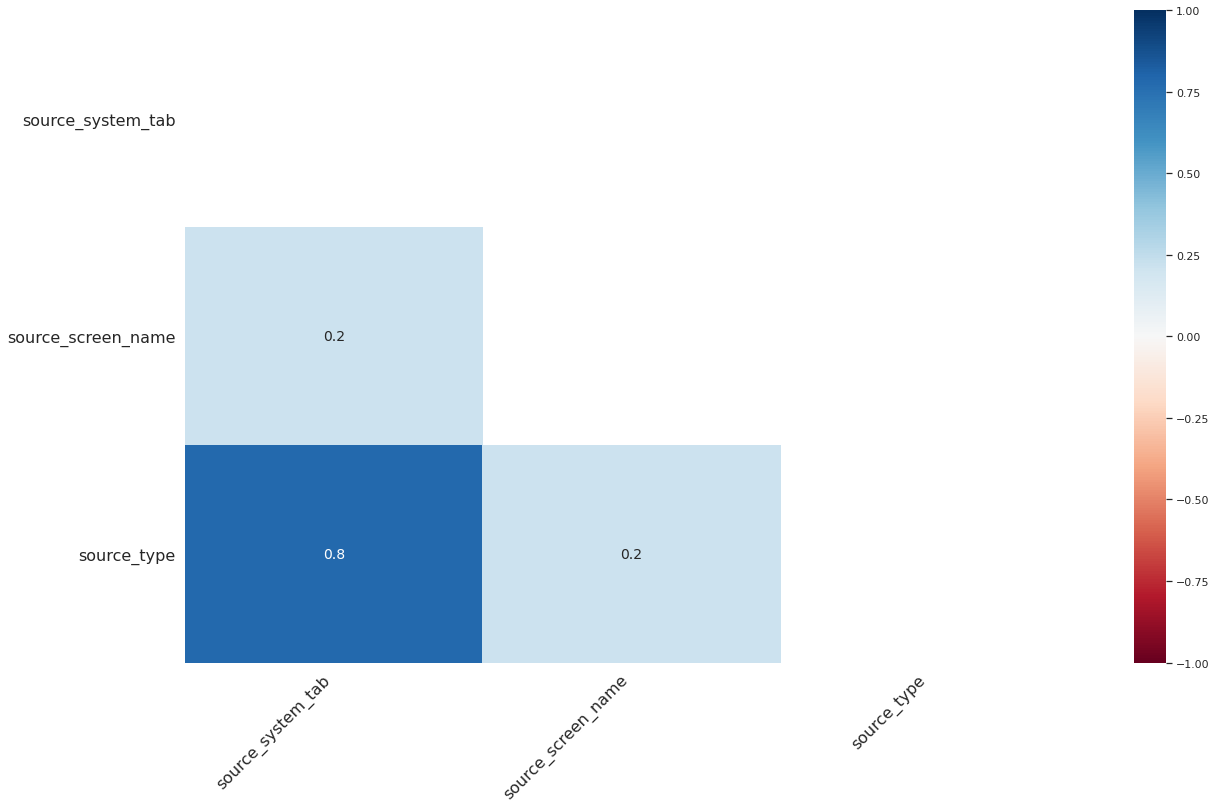

In [ ]:
msno.heatmap(train)

From the above missing values histogram, we can observe a strong positive correlation between 'source_system_tab' & 'source_type', that is, if one of these two tabs have a value missing, the other one will also have a high probability of the value being missing.

Dendrogram:

The dendrogram is a visual representation of the compound correlation data. The individual compounds are arranged along the bottom of the dendrogram and referred to as leaf nodes. Compound clusters are formed by joining individual compounds or existing compound clusters with the join point referred to as a node. This can be seen in the diagram above. At each dendrogram node we have a right and left sub-branch of clustered compounds. The vertical axis is labelled distance and refers to a distance measure between compounds or compound clusters. The height of the node can be thought of as the distance value between the right and left sub-branch clusters.

A dendrogram is a diagram that shows the hierarchical relationship between objects. The key to interpreting a dendrogram is to focus on the height at which any two objects are joined together. In the dendrogram above, the height of the dendrogram indicates the order in which the clusters were joined. It is important to appreciate that the dendrogram is a summary of the distance matrix, and, as occurs with most summaries, information is lost. To use some jargon, a dendrogram is only accurate when data satisfies the ultrametric tree inequality, and this is unlikely for any real-world data. The consequence of the information loss is that the dendrograms are most accurate at the bottom, showing which items are very similar.

More about dendrograms:

https://www.data-to-viz.com/graph/dendrogram.html

https://www.nonlinear.com/support/progenesis/comet/faq/v2.0/dendrogram.aspx

https://medium.com/@displayr/what-is-a-dendrogram-9de4fc1f131e

Ultrametric Tree Inequality: http://www.cs.technion.ac.il/~moran/COURSES/papers/SaTv77.pdf

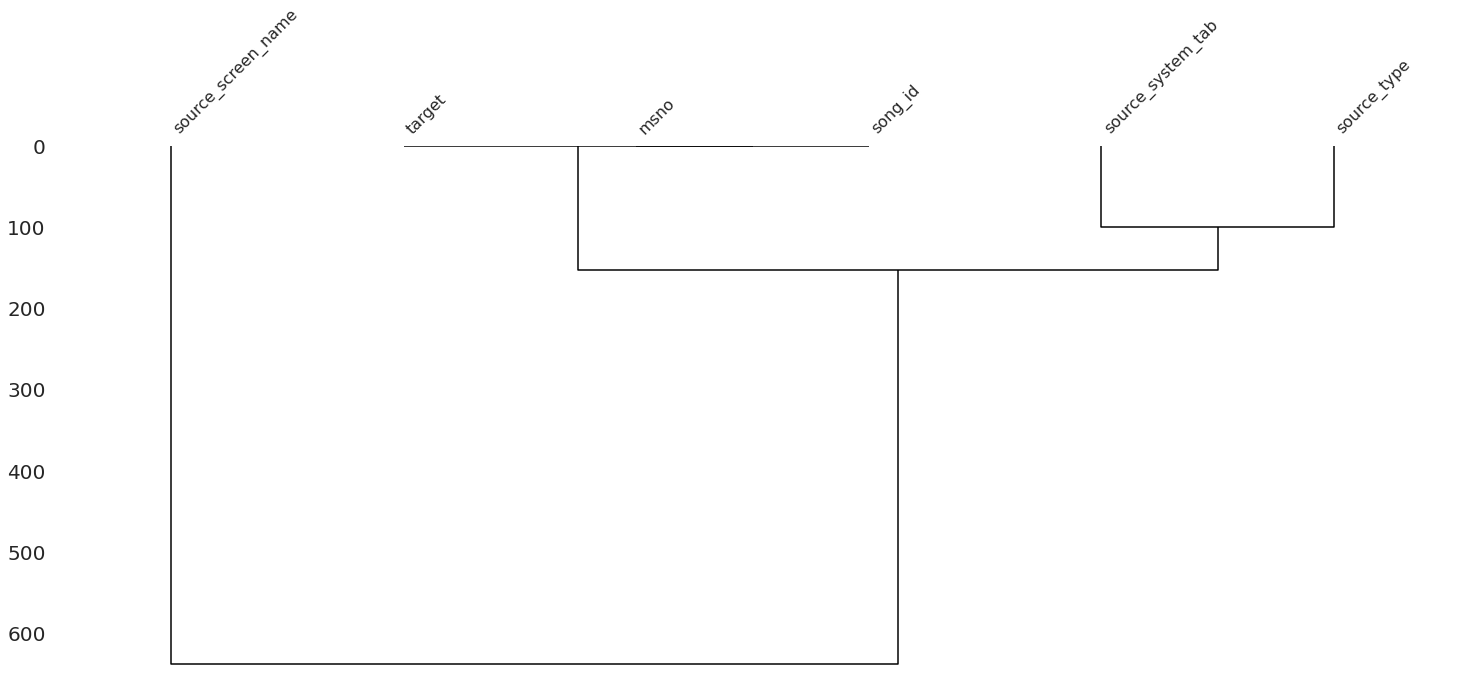

In [ ]:
msno.dendrogram(train)

From the above dendrogram, following correlation in missing values can be observed:

'source_system_tab' and 'source_type' (also seen previously).

Heatmap:

The main intention of Seaborn heatmap is to visualize the correlation matrix of data for feature selection to solve business problems.

https://indianaiproduction.com/seaborn-heatmap/

https://www.journaldev.com/38954/seaborn-heatmap-tutorial

https://seaborn.pydata.org/generated/seaborn.heatmap.html

<h3>3.2 Explore Member Data<h3>

In [ ]:
members.shape

(34403, 7)

Thus, mebers dataframe has more than 34k rows/entries and seven attributes. More details of these attributes are as follows.

In [ ]:
members.columns

Index(['msno', 'city', 'bd', 'gender', 'registered_via',
       'registration_init_time', 'expiration_date'],
      dtype='object')

In [ ]:
members.head()

,msno,city,bd,gender,registered_via,registration_init_time,expiration_date
0,XQxgAYj3klVKjR3oxPPXYYFp4soD4TuBghkhMTD4oTw=,1,0,NaN,7,20110820,20170920
1,UizsfmJb9mV54qE9hCYyU07Va97c0lCRLEQX3ae+ztM=,1,0,NaN,7,20150628,20170622
2,D8nEhsIOBSoE6VthTaqDX8U6lqjJ7dLdr72mOyLya2A=,1,0,NaN,4,20160411,20170712
3,mCuD+tZ1hERA/o5GPqk38e041J8ZsBaLcu7nGoIIvhI=,1,0,NaN,9,20150906,20150907
4,q4HRBfVSssAFS9iRfxWrohxuk9kCYMKjHOEagUMV6rQ=,1,0,NaN,4,20170126,20170613


In [ ]:
members.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34403 entries, 0 to 34402
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   msno                    34403 non-null  object
 1   city                    34403 non-null  int64 
 2   bd                      34403 non-null  int64 
 3   gender                  14501 non-null  object
 4   registered_via          34403 non-null  int64 
 5   registration_init_time  34403 non-null  int64 
 6   expiration_date         34403 non-null  int64 
dtypes: int64(5), object(2)
memory usage: 1.8+ MB


user information.

msno

city

bd: age. Note: this column has outlier values, please use your judgement.

gender

registered_via: registration method

registration_init_time: format %Y%m%d

expiration_date: format %Y%m%d

'gender' is the only attribute in this dataframe that has some null values.

In [ ]:
members.describe()

,city,bd,registered_via,registration_init_time,expiration_date
count,34403.000000,34403.000000,34403.000000,3.440300e+04,3.440300e+04
mean,5.371276,12.280935,5.953376,2.013994e+07,2.016901e+07
std,6.243929,18.170251,2.287534,2.954015e+04,7.320925e+03
min,1.000000,-43.000000,3.000000,2.004033e+07,1.970010e+07
25%,1.000000,0.000000,4.000000,2.012103e+07,2.017020e+07
50%,1.000000,0.000000,7.000000,2.015090e+07,2.017091e+07
75%,10.000000,25.000000,9.000000,2.016110e+07,2.017093e+07
max,22.000000,1051.000000,16.000000,2.017023e+07,2.020102e+07


Converting columns 'registration_init_time' and 'expiration_date' to type datetime.

In [ ]:
members.registration_init_time = pd.to_datetime(members.registration_init_time.astype('str'))
members.expiration_date = pd.to_datetime(members.expiration_date.astype('str'))

In [ ]:
members.head()

,msno,city,bd,gender,registered_via,registration_init_time,expiration_date
0,XQxgAYj3klVKjR3oxPPXYYFp4soD4TuBghkhMTD4oTw=,1,0,NaN,7,2011-08-20,2017-09-20
1,UizsfmJb9mV54qE9hCYyU07Va97c0lCRLEQX3ae+ztM=,1,0,NaN,7,2015-06-28,2017-06-22
2,D8nEhsIOBSoE6VthTaqDX8U6lqjJ7dLdr72mOyLya2A=,1,0,NaN,4,2016-04-11,2017-07-12
3,mCuD+tZ1hERA/o5GPqk38e041J8ZsBaLcu7nGoIIvhI=,1,0,NaN,9,2015-09-06,2015-09-07
4,q4HRBfVSssAFS9iRfxWrohxuk9kCYMKjHOEagUMV6rQ=,1,0,NaN,4,2017-01-26,2017-06-13


In [ ]:
members.dtypes

msno                              object
city                               int64
bd                                 int64
gender                            object
registered_via                     int64
registration_init_time    datetime64[ns]
expiration_date           datetime64[ns]
dtype: object

Thus, conversion of type in columns 'registration_init_time' and 'expiration_date' can now be observed.

In [ ]:
members.isnull().sum(axis = 0)

msno                          0
city                          0
bd                            0
gender                    19902
registered_via                0
registration_init_time        0
expiration_date               0
dtype: int64

'gender' column has a total of 19902 null values out of total 34403 values. That is, around 57.8496% of the values are missing.

In [ ]:
number = members["gender"].isna().sum()
percentage=(number/len(members['gender']))*100

print("Total number of rows in members dataframe:  ", len(members['gender']))
print("Number of NaN values in gender column:  ", number)
print("Number of non-NaN values in gender column:  ", (len(members['gender'])-number))
print("Total percentage of NaN values in gender column:  {}" .format(percentage))

Total number of rows in members dataframe:   34403
Number of NaN values in gender column:   19902
Number of non-NaN values in gender column:   14501
Total percentage of NaN values in gender column:  57.84960613899951


<h3>3.3 Explore Songs Data</h3>

In [ ]:
songs.shape

(2296320, 7)

Thus, there are a total of 2296320 songs in the dataframe with 7 columns/attributes. Details of these attributes/columns are shown below.

In [ ]:
songs.columns

Index(['song_id', 'song_length', 'genre_ids', 'artist_name', 'composer',
       'lyricist', 'language'],
      dtype='object')

In [ ]:
songs.head()

,song_id,song_length,genre_ids,artist_name,composer,lyricist,language
0,CXoTN1eb7AI+DntdU1vbcwGRV4SCIDxZu+YD8JP8r4E=,247640,465,張信哲 (Jeff Chang),董貞,何啟弘,3.0
1,o0kFgae9QtnYgRkVPqLJwa05zIhRlUjfF7O1tDw0ZDU=,197328,444,BLACKPINK,TEDDY| FUTURE BOUNCE| Bekuh BOOM,TEDDY,31.0
2,DwVvVurfpuz+XPuFvucclVQEyPqcpUkHR0ne1RQzPs0=,231781,465,SUPER JUNIOR,NaN,NaN,31.0
3,dKMBWoZyScdxSkihKG+Vf47nc18N9q4m58+b4e7dSSE=,273554,465,S.H.E,湯小康,徐世珍,3.0
4,W3bqWd3T+VeHFzHAUfARgW9AvVRaF4N5Yzm4Mr6Eo/o=,140329,726,貴族精選,Traditional,Traditional,52.0


In [ ]:
songs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2296320 entries, 0 to 2296319
Data columns (total 7 columns):
 #   Column       Dtype  
---  ------       -----  
 0   song_id      object 
 1   song_length  int64  
 2   genre_ids    object 
 3   artist_name  object 
 4   composer     object 
 5   lyricist     object 
 6   language     float64
dtypes: float64(1), int64(1), object(5)
memory usage: 122.6+ MB


The songs. Note that data is in unicode.

song_id

song_length: in ms

genre_ids: genre category. Some songs have multiple genres and they are separated by |

artist_name

composer

lyricist

language

In [ ]:
songs.describe()

,song_length,language
count,2.296320e+06,2.296319e+06
mean,2.469935e+05,3.237800e+01
std,1.609200e+05,2.433241e+01
min,1.850000e+02,-1.000000e+00
25%,1.836000e+05,-1.000000e+00
50%,2.266270e+05,5.200000e+01
75%,2.772690e+05,5.200000e+01
max,1.217385e+07,5.900000e+01


In [ ]:
songs.isnull().sum(axis = 0)

song_id              0
song_length          0
genre_ids        94116
artist_name          0
composer       1071354
lyricist       1945268
language             1
dtype: int64

Columns 'composer' and 'lyricist' contain 1071354 and 1945268 null values respectively, that is 46.6552% and 84.7124% null values respectively, which need to be carefully handled, while genre_ids have 94116, that is 4.0985% null values.

<h3>3.4 Explore Extra Song Data</h3>

In [ ]:
song_extra_info.shape

(2295971, 3)

There are a total of 2295971 rows/entries in the song_extra_info dataframe with 3 columns/attributes.

In [ ]:
song_extra_info.columns

Index(['song_id', 'name', 'isrc'], dtype='object')

In [ ]:
song_extra_info.head()

,song_id,name,isrc
0,LP7pLJoJFBvyuUwvu+oLzjT+bI+UeBPURCecJsX1jjs=,我們,TWUM71200043
1,ClazTFnk6r0Bnuie44bocdNMM3rdlrq0bCGAsGUWcHE=,Let Me Love You,QMZSY1600015
2,u2ja/bZE3zhCGxvbbOB3zOoUjx27u40cf5g09UXMoKQ=,原諒我,TWA530887303
3,92Fqsy0+p6+RHe2EoLKjHahORHR1Kq1TBJoClW9v+Ts=,Classic,USSM11301446
4,0QFmz/+rJy1Q56C1DuYqT9hKKqi5TUqx0sN0IwvoHrw=,愛投羅網,TWA471306001


In [ ]:
song_extra_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2295971 entries, 0 to 2295970
Data columns (total 3 columns):
 #   Column   Dtype 
---  ------   ----- 
 0   song_id  object
 1   name     object
 2   isrc     object
dtypes: object(3)
memory usage: 52.6+ MB


song_id

song name - the name of the song.

isrc - International Standard Recording Code, theoretically can be used as an identity of a song. However, what worth to note is, ISRCs generated from providers have not been officially verified; therefore the information in ISRC, such as country code and reference year, can be misleading/incorrect. Multiple songs could share one ISRC since a single recording could be re-published several times.

In [ ]:
song_extra_info.describe()

,song_id,name,isrc
count,2295971,2295969,2159423
unique,2295971,1168979,1806825
top,MeW26EsNobYSRDYqP6plBkkaG9TqFgQMb1mvuSjS09Y=,Intro,GBPS81518952
freq,1,1734,207


Thus, we have a total of 2295971 songs in the 'song_extra_info' dataframe out of which all are unique, that is, there are no duplicate songs present in the dataframe. 

In [ ]:
song_extra_info.isnull().sum(axis=0)

song_id         0
name            2
isrc       136548
dtype: int64

2 entries in the 'name' column are null while the number of null entries increases to 136548 (5.9472%) in the 'isrc' column.

<h3>3.5 Explore Test Data</h3>

In [ ]:
test.shape

(2556790, 6)

Test data contains a total of 2556790 rows/entries with 6 column/attributes with each of them shown below.

In [ ]:
test.columns

Index(['id', 'msno', 'song_id', 'source_system_tab', 'source_screen_name',
       'source_type'],
      dtype='object')

In [ ]:
test.head()

,id,msno,song_id,source_system_tab,source_screen_name,source_type
0,0,V8ruy7SGk7tDm3zA51DPpn6qutt+vmKMBKa21dp54uM=,WmHKgKMlp1lQMecNdNvDMkvIycZYHnFwDT72I5sIssc=,my library,Local playlist more,local-library
1,1,V8ruy7SGk7tDm3zA51DPpn6qutt+vmKMBKa21dp54uM=,y/rsZ9DC7FwK5F2PK2D5mj+aOBUJAjuu3dZ14NgE0vM=,my library,Local playlist more,local-library
2,2,/uQAlrAkaczV+nWCd2sPF2ekvXPRipV7q0l+gbLuxjw=,8eZLFOdGVdXBSqoAv5nsLigeH2BvKXzTQYtUM53I0k4=,discover,NaN,song-based-playlist
3,3,1a6oo/iXKatxQx4eS9zTVD+KlSVaAFbTIqVvwLC1Y0k=,ztCf8thYsS4YN3GcIL/bvoxLm/T5mYBVKOO4C9NiVfQ=,radio,Radio,radio
4,4,1a6oo/iXKatxQx4eS9zTVD+KlSVaAFbTIqVvwLC1Y0k=,MKVMpslKcQhMaFEgcEQhEfi5+RZhMYlU3eRDpySrH8Y=,radio,Radio,radio


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2556790 entries, 0 to 2556789
Data columns (total 6 columns):
 #   Column              Dtype 
---  ------              ----- 
 0   id                  int64 
 1   msno                object
 2   song_id             object
 3   source_system_tab   object
 4   source_screen_name  object
 5   source_type         object
dtypes: int64(1), object(5)
memory usage: 117.0+ MB


id: row id (will be used for submission)

msno: user id

song_id: song id

source_system_tab: the name of the tab where the event was triggered. System tabs are used to categorize KKBOX mobile apps functions. For example, tab my library contains functions to manipulate the local storage, and tab search contains functions relating to search.

source_screen_name: name of the layout a user sees.

source_type: an entry point a user first plays music on mobile apps. An entry point could be album, online-playlist, song .. etc.

In [ ]:
test.describe()

,id
count,2.556790e+06
mean,1.278394e+06
std,7.380818e+05
min,0.000000e+00
25%,6.391972e+05
50%,1.278394e+06
75%,1.917592e+06
max,2.556789e+06


<h3>3.6 Merging Data & Analysis<h3>

Now let's merge train, members, and songs dataframes into one single dataframe using the common attributes.

In [ ]:
train_members_merged = pd.merge(train, members, on='msno', how='left')
songs_song_extra_info_merged = songs.merge(song_extra_info, on='song_id')

train_data_merged = pd.merge(train_members_merged, songs_song_extra_info_merged, on='song_id', how='left')

Reppeating the same for test data.

In [ ]:
#test_members_merged = pd.merge(test, members, on='msno', how='left')

#test_data_merged = pd.merge(test_members_merged, songs_song_extra_info_merged, on='song_id', how='left')

*Uploading these merged dataframes to Google Drive...*

https://stackoverflow.com/questions/53898836/export-dataframe-as-csv-file-from-google-colab-to-google-drive

In [ ]:
train_data_merged.to_csv('train_data_merged.csv')
!cp train_data_merged.csv "/content/gdrive/My Drive/Kaggle_KKBoxMusic"

cp: 'train_data_merged.csv' and '/content/gdrive/My Drive/Kaggle_KKBoxMusic/train_data_merged.csv' are the same file


In [ ]:
#test_data_merged.to_csv('test_data_merged.csv')
#!cp test_data_merged.csv "/content/gdrive/My Drive/Kaggle_KKBoxMusic"

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%cd /content/gdrive/My Drive/Kaggle_KKBoxMusic

/content/gdrive/My Drive/Kaggle_KKBoxMusic


In [ ]:
!pwd

/content/gdrive/My Drive/Kaggle_KKBoxMusic


In [ ]:
import os
os.getcwd()

'/content/gdrive/My Drive/Kaggle_KKBoxMusic'

In [ ]:
!ls

kaggle.json  sample_submission.csv.7z  songs.csv  train.csv
members.csv  song_extra_info.csv       test.csv   train_data_merged.csv


In [ ]:
train_data_merged = pd.read_csv('train_data_merged.csv')

In [ ]:
train_data_merged.shape

(7377418, 20)

Thus, our newly formed dataframe 'train_merged_data' has a total of 7377418 entries with 20 attributes/dimensions. 

In [ ]:
train_data_merged.columns

Index(['msno', 'song_id', 'source_system_tab', 'source_screen_name',
       'source_type', 'target', 'city', 'bd', 'gender', 'registered_via',
       'registration_init_time', 'expiration_date', 'song_length', 'genre_ids',
       'artist_name', 'composer', 'lyricist', 'language', 'name', 'isrc'],
      dtype='object')

In [ ]:
train_data_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7377418 entries, 0 to 7377417
Data columns (total 20 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   msno                    object        
 1   song_id                 object        
 2   source_system_tab       object        
 3   source_screen_name      object        
 4   source_type             object        
 5   target                  int64         
 6   city                    int64         
 7   bd                      int64         
 8   gender                  object        
 9   registered_via          int64         
 10  registration_init_time  datetime64[ns]
 11  expiration_date         datetime64[ns]
 12  song_length             float64       
 13  genre_ids               object        
 14  artist_name             object        
 15  composer                object        
 16  lyricist                object        
 17  language                float64       
 18  na

In [ ]:
train_data_merged.describe()

,target,city,bd,registered_via,song_length,language
count,7.377418e+06,7.377418e+06,7.377418e+06,7.377418e+06,7.375849e+06,7.375813e+06
mean,5.035171e-01,7.511399e+00,1.753927e+01,6.794068e+00,2.451213e+05,1.860810e+01
std,4.999877e-01,6.641625e+00,2.155447e+01,2.275774e+00,6.734491e+04,2.117688e+01
min,0.000000e+00,1.000000e+00,-4.300000e+01,3.000000e+00,1.393000e+03,-1.000000e+00
25%,0.000000e+00,1.000000e+00,0.000000e+00,4.000000e+00,2.147260e+05,3.000000e+00
50%,1.000000e+00,5.000000e+00,2.100000e+01,7.000000e+00,2.418120e+05,3.000000e+00
75%,1.000000e+00,1.300000e+01,2.900000e+01,9.000000e+00,2.721690e+05,5.200000e+01
max,1.000000e+00,2.200000e+01,1.051000e+03,1.300000e+01,1.085171e+07,5.900000e+01


In [ ]:
train_data_merged.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target,city,bd,gender,registered_via,registration_init_time,expiration_date,song_length,genre_ids,artist_name,composer,lyricist,language,name,isrc
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1,1,0,NaN,7,2012-01-02,2017-10-05,206471.0,359,Bastille,Dan Smith| Mark Crew,NaN,52.0,Good Grief,GBUM71602854
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1,13,24,female,9,2011-05-25,2017-09-11,284584.0,1259,Various Artists,NaN,NaN,52.0,Lords of Cardboard,US3C69910183
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1,13,24,female,9,2011-05-25,2017-09-11,225396.0,1259,Nas,N. Jones、W. Adams、J. Lordan、D. Ingle,NaN,52.0,Hip Hop Is Dead(Album Version (Edited)),USUM70618761
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1,13,24,female,9,2011-05-25,2017-09-11,255512.0,1019,Soundway,Kwadwo Donkoh,NaN,-1.0,Disco Africa,GBUQH1000063
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1,1,0,NaN,7,2012-01-02,2017-10-05,187802.0,1011,Brett Young,Brett Young| Kelly Archer| Justin Ebach,NaN,52.0,Sleep Without You,QM3E21606003


<h3>3.7 Missing Values Analysis<h3>

In [ ]:
def check_for_missing_values(df):
  '''Function to check missing values in given df'''
  for column in df.columns:
    number_of_nan = df[column].isnull().sum()
    total = df.shape[0]
    percent = number_of_nan / total * 100
    print(column, 'has',  number_of_nan, 'out of total', total, 'values missing, that is, {:.4f}% missing values'.format(percent))

In [ ]:
print("--------------------------------------------------------------------------------------------------------------")
print('\nMissing Value analysis for train data:\n')
check_for_missing_values(train)
print("--------------------------------------------------------------------------------------------------------------")
print('\nMissing Value analysis for members data:\n')
check_for_missing_values(members)
print("--------------------------------------------------------------------------------------------------------------")
print('\nMissing Value analysis for songs data:\n')
check_for_missing_values(songs)
print("--------------------------------------------------------------------------------------------------------------")
print('\nMissing Value analysis for song extra info data:\n')
check_for_missing_values(song_extra_info)
print("--------------------------------------------------------------------------------------------------------------")

--------------------------------------------------------------------------------------------------------------

Missing Value analysis for train data:

msno has 0 out of total 7377418 values missing, that is, 0.0000% missing values
song_id has 0 out of total 7377418 values missing, that is, 0.0000% missing values
source_system_tab has 24849 out of total 7377418 values missing, that is, 0.3368% missing values
source_screen_name has 414804 out of total 7377418 values missing, that is, 5.6226% missing values
source_type has 21539 out of total 7377418 values missing, that is, 0.2920% missing values
target has 0 out of total 7377418 values missing, that is, 0.0000% missing values
--------------------------------------------------------------------------------------------------------------

Missing Value analysis for members data:

msno has 0 out of total 34403 values missing, that is, 0.0000% missing values
city has 0 out of total 34403 values missing, that is, 0.0000% missing values
bd has

Observations:
1. The 'train' dataframe contains almost negligible amount of missing values and is thus, a good thing.
2. The only column with missing values in the 'members' dataframe is the 'gender' column which has about 57.8496 of its values missing.
3. Columns 'composer' and 'lyricist' in the 'songs' dataframe have respectively 46.6553% and 84.7124% of its values missing, while the column 'genre_ids' have just 4.0986% of its values missing.
4. Looking at the 'songs_extra_info' dataframe, we can observe that just 5.9473% of the values are missing in the 'isrc' column. Rest of the columns remain unhampered.

**Now let's dive deep into some more analysis on the merged data.**

Box Plot:

A boxplot is a standardized way of displaying the distribution of data based on a five number summary (“minimum”, first quartile (Q1), median, third quartile (Q3), and “maximum”). It can tell you about your outliers and what their values are. It can also tell you if your data is symmetrical, how tightly your data is grouped, and if and how your data is skewed. 
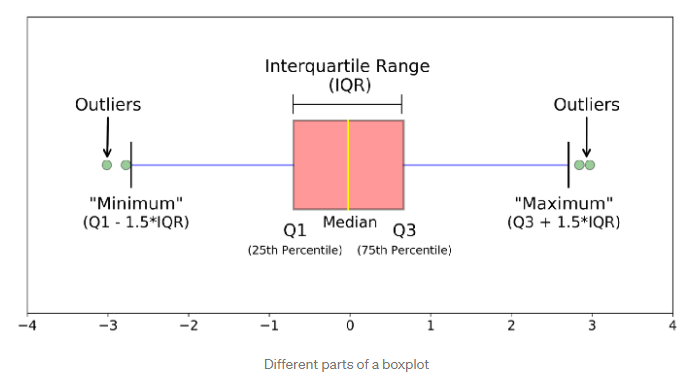

References:

https://towardsdatascience.com/understanding-boxplots-5e2df7bcbd51

https://www.wellbeingatschool.org.nz/information-sheet/understanding-and-interpreting-box-plots

https://en.wikipedia.org/wiki/Box_plot

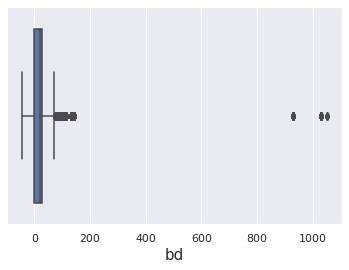

In [ ]:
sns.boxplot(x=train_data_merged['bd'])

Thus, we can observe that most of the age data lies in the range 0 to 50 years of age. There are some values less than 0 and some greater than 120 which are practically impossible to be true. 

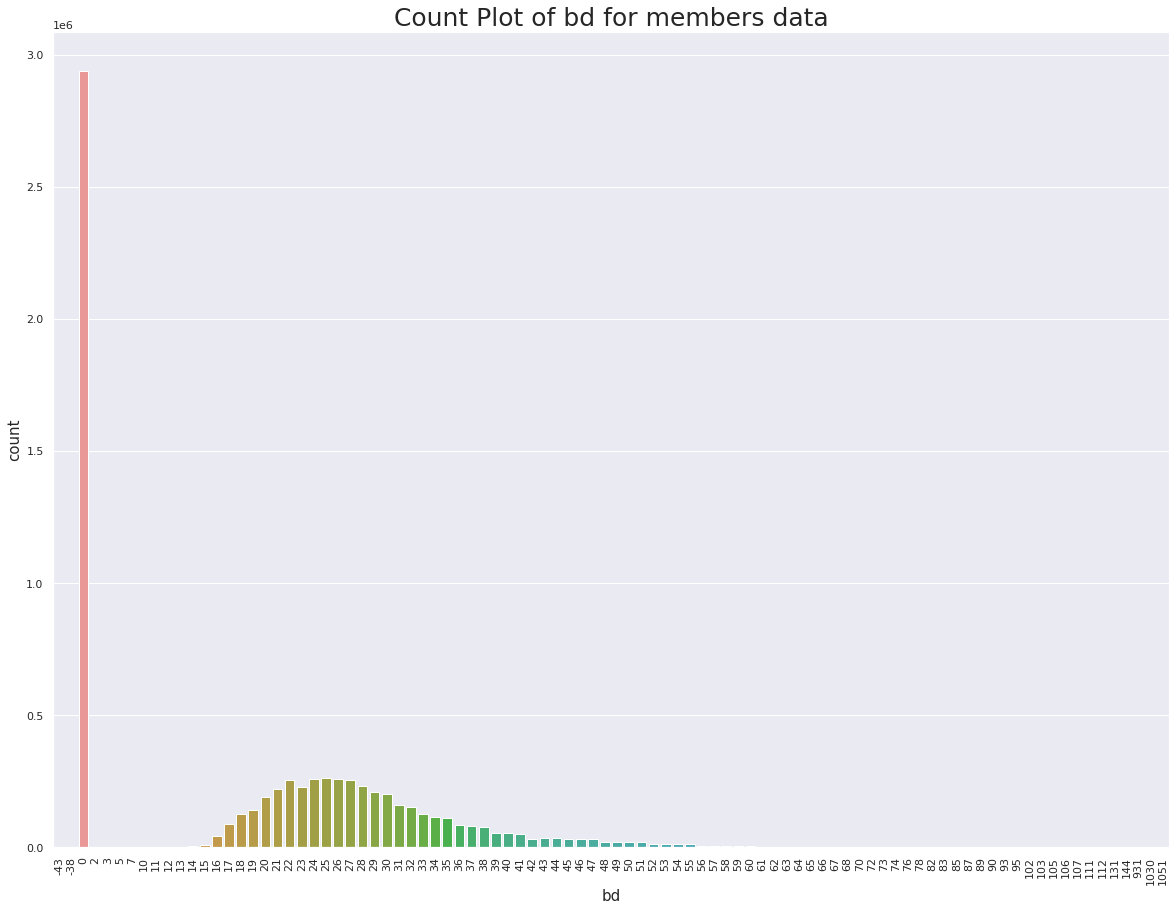

In [ ]:
plt.figure(figsize=(20, 15)) 
sns.countplot(x='bd', data=train_data_merged) 
plt.xticks(rotation='90')
plt.title('Count Plot of bd for members data', fontsize=25)
plt.show()

A lot of values in 'bd' column are zeros, while many lie in the range 16 to 55 years of age. There are a lot of values less than zero, zero or greater than 120 years of age which are practically impossible to be true, thus, they need to be processed.

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


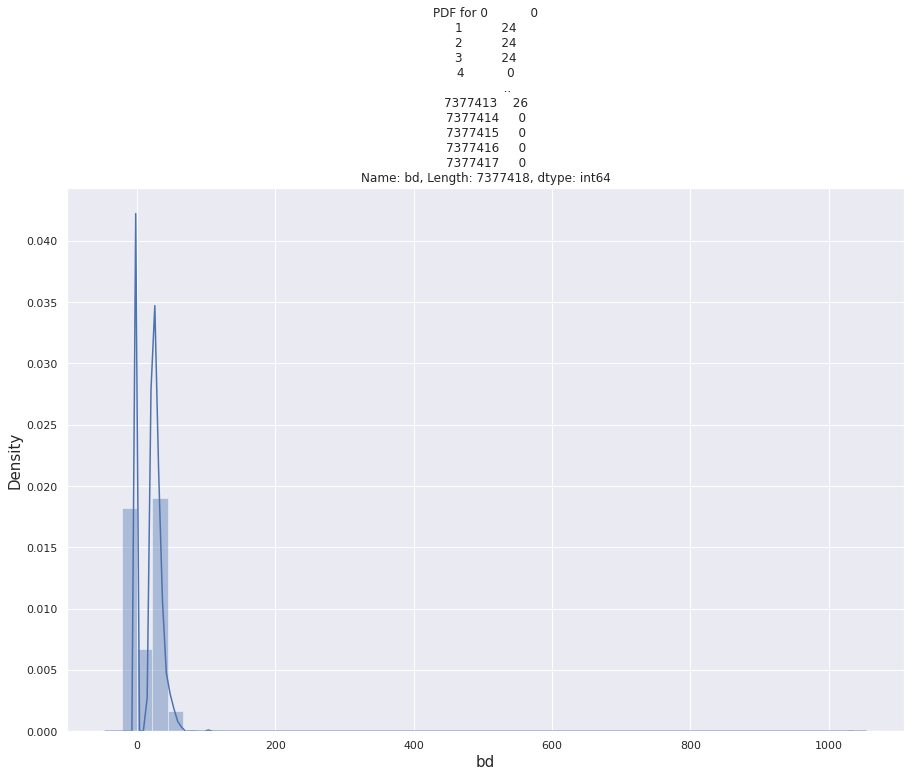

In [ ]:
# Plotting PDF for 'bd'
plot_pdf_cdf(train_data_merged['bd'], False)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


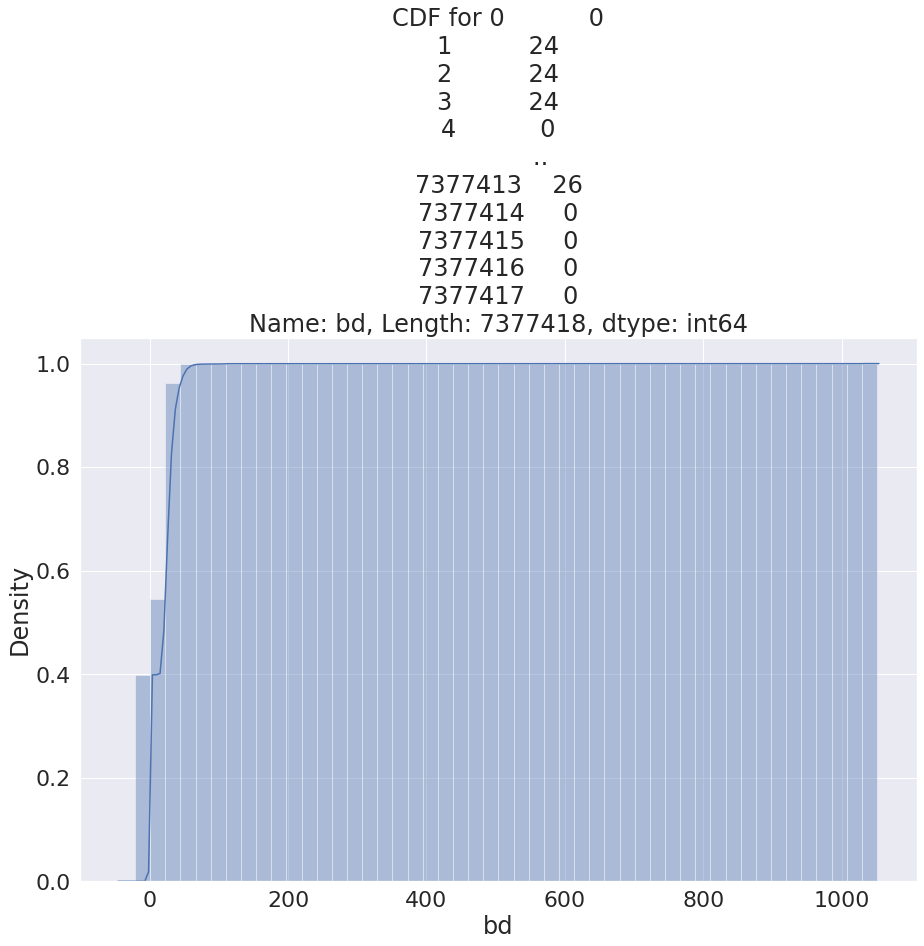

In [ ]:
# Plotting CDF for 'bd'
plot_pdf_cdf(train_data_merged['bd'], True)

In [ ]:
calc_percentiles(train_data_merged, 'bd', 0, 70, 5)

0 th percentile value of given attribute is -43.0
5 th percentile value of given attribute is 0.0
10 th percentile value of given attribute is 0.0
15 th percentile value of given attribute is 0.0
20 th percentile value of given attribute is 0.0
25 th percentile value of given attribute is 0.0
30 th percentile value of given attribute is 0.0
35 th percentile value of given attribute is 0.0
40 th percentile value of given attribute is 15.0
45 th percentile value of given attribute is 19.0
50 th percentile value of given attribute is 21.0
55 th percentile value of given attribute is 23.0
60 th percentile value of given attribute is 24.0
65 th percentile value of given attribute is 26.0


Thus, it can be observed that 35% of the values are less than or equal to zero.

In [ ]:
calc_percentiles(train_data_merged, 'bd', 80, 96, 2)

80 th percentile value of given attribute is 30.0
82 th percentile value of given attribute is 31.0
84 th percentile value of given attribute is 32.0
86 th percentile value of given attribute is 33.0
88 th percentile value of given attribute is 35.0
90 th percentile value of given attribute is 36.0
92 th percentile value of given attribute is 38.0
94 th percentile value of given attribute is 40.0


In [ ]:
calc_percentiles(train_data_merged, 'bd', 95, 101, 1)

95 th percentile value of given attribute is 42.0
96 th percentile value of given attribute is 44.0
97 th percentile value of given attribute is 46.0
98 th percentile value of given attribute is 50.0
99 th percentile value of given attribute is 54.0
100 th percentile value of given attribute is 1051.0


Around 66% of the values lie between 0 & 54 years of age. Rest needs to be handled.

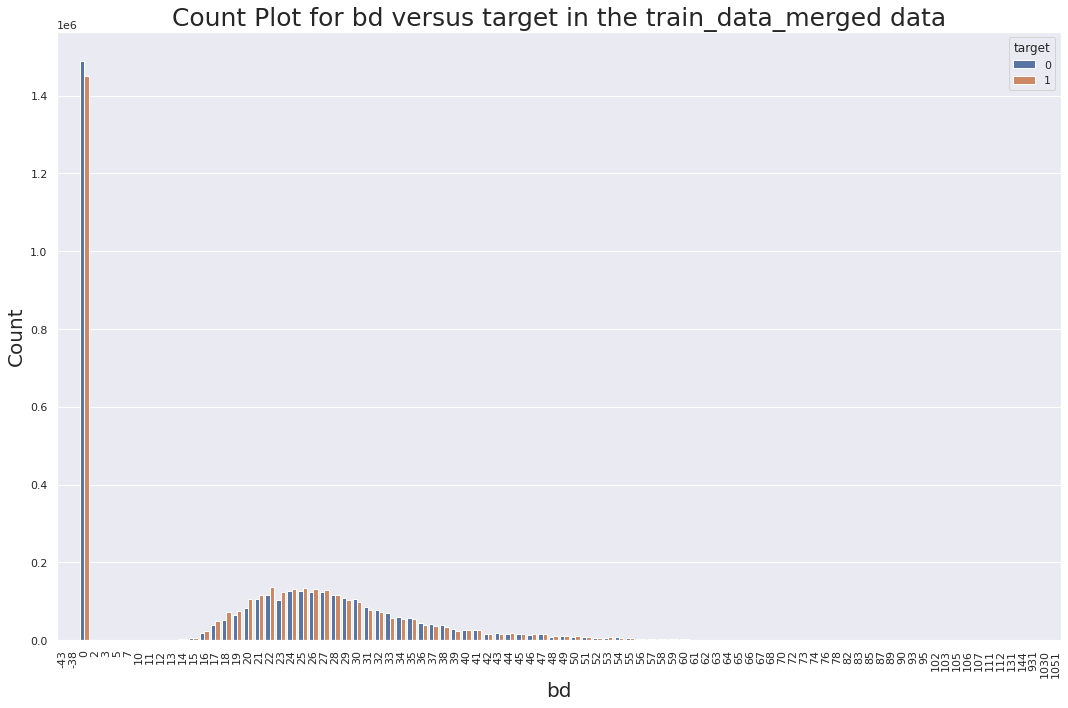

In [ ]:
count_plot(train_data_merged, 'bd', 'target', 'train_data_merged')

All age groups have almost equal ratio of target values and no single age group can be observed contributing to any one target value. They are evenly poised.

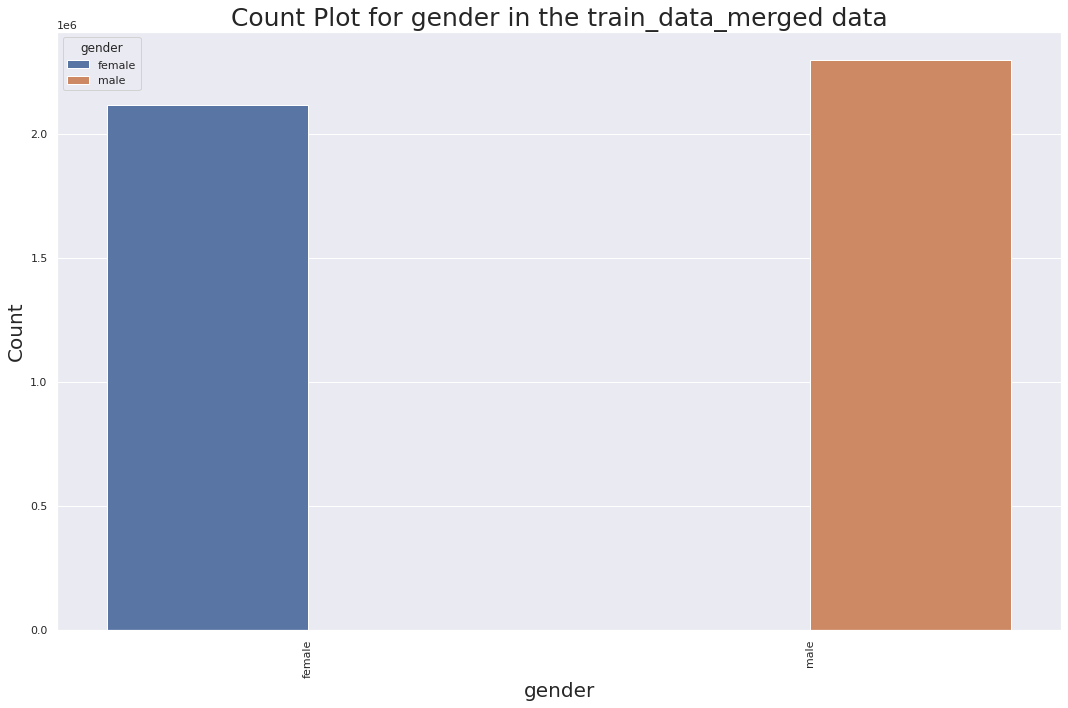

In [ ]:
count_plot(train_data_merged, 'gender', 'gender', 'train_data_merged')

Given data is balanced around the 'gender' attribute.

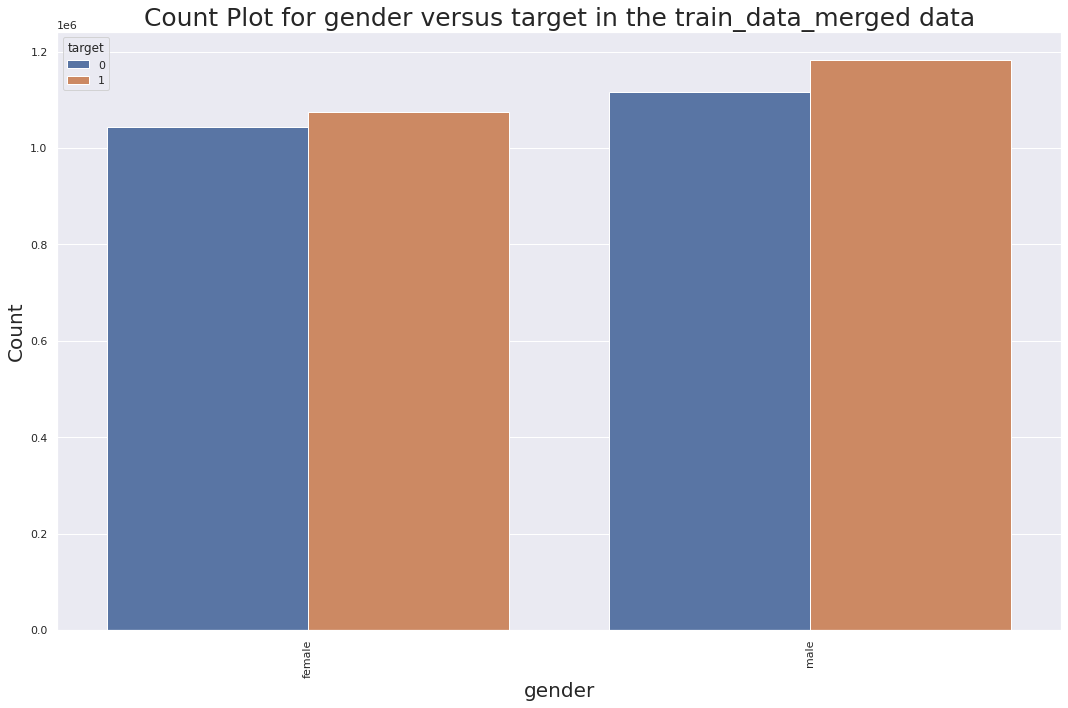

In [ ]:
count_plot(train_data_merged, 'gender', 'target', 'train_data_merged')

Both genders seem to be evenly poised towards both target values.

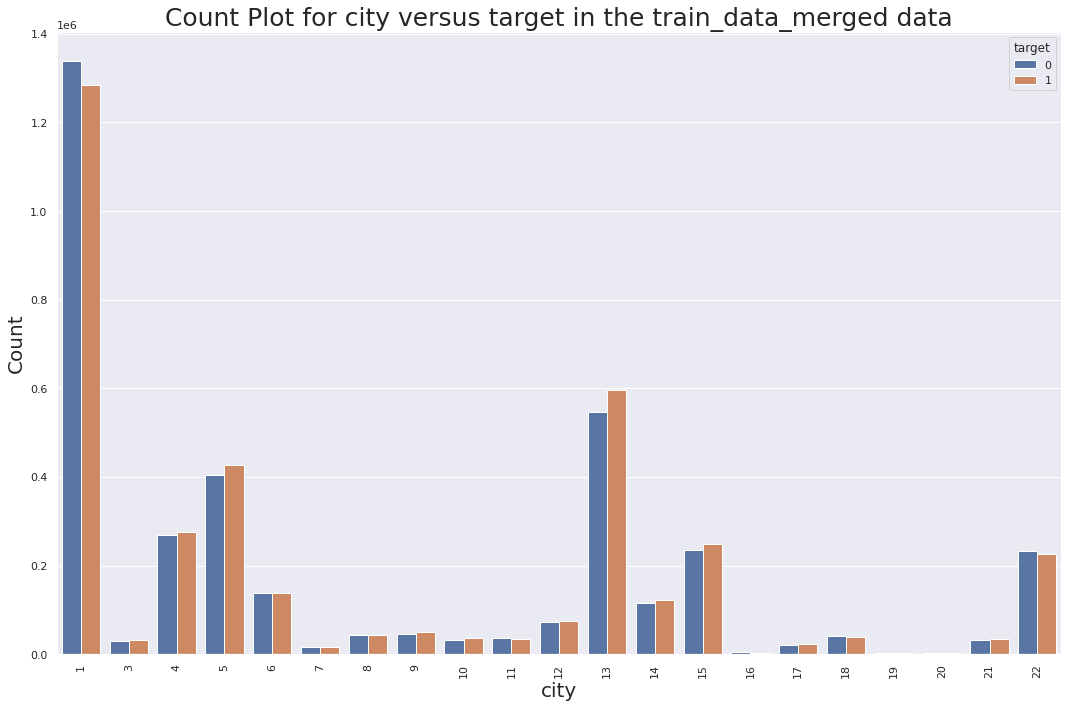

In [ ]:
count_plot(train_data_merged, 'city', 'target', 'train_data_merged')

From the above plot, it can be observed most of the usres in the dataset provided belong to city with id 1 followed by cities with ids 13 & 5. Both the 'target' values are almost in equal numbers in all the cities.

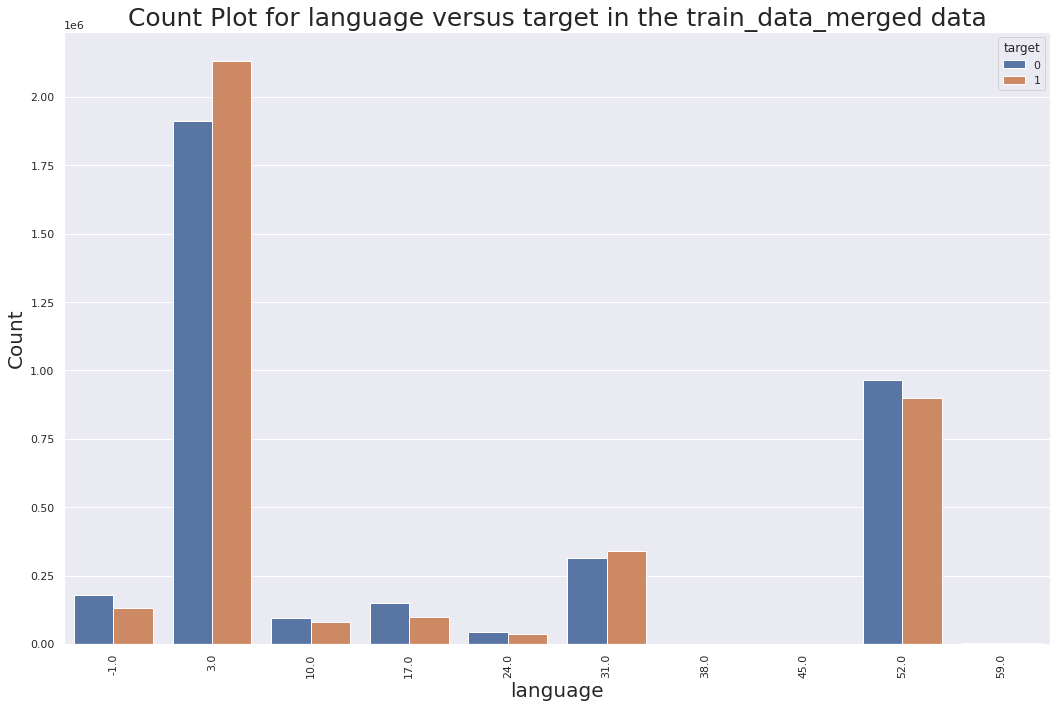

In [ ]:
count_plot(train_data_merged, 'language', 'target', 'train_data_merged')

Most of the users tend ti preefr the language with id 3 followed by 52. There isn't any significant difference in the 'target' values they contribute to. But after looking at the previous plot of cities data, we can infer that users/people living in cities 1 & 13 prefer languages 3 & 52 respectively. 

In [ ]:
def convert_song_duration_to_minutes(df):
    '''function to convert song duration from milliseconds to minutes'''
    duration=[]
    for i in (df["song_length"]):
        #minutes = int((i / 1000) / 60)
        minutes = ((i/(1000*60))%60)
        minutes = round(minutes)
        duration.append(minutes)
    #adding new column to df
    df["song_duration_minutes"] = duration
    return df

In [ ]:
print(train_data_merged['song_length'].mean())
print(train_data_merged['song_length'].median())

245121.3220819732
241812.0


In [ ]:
train_data_merged["song_length"] = train_data_merged["song_length"].replace(0, train_data_merged['song_length'].mean())
train_data_merged["song_length"] = train_data_merged["song_length"].replace(np.nan, train_data_merged['song_length'].mean())

In [ ]:
train_data_merged = convert_song_duration_to_minutes(train_data_merged)

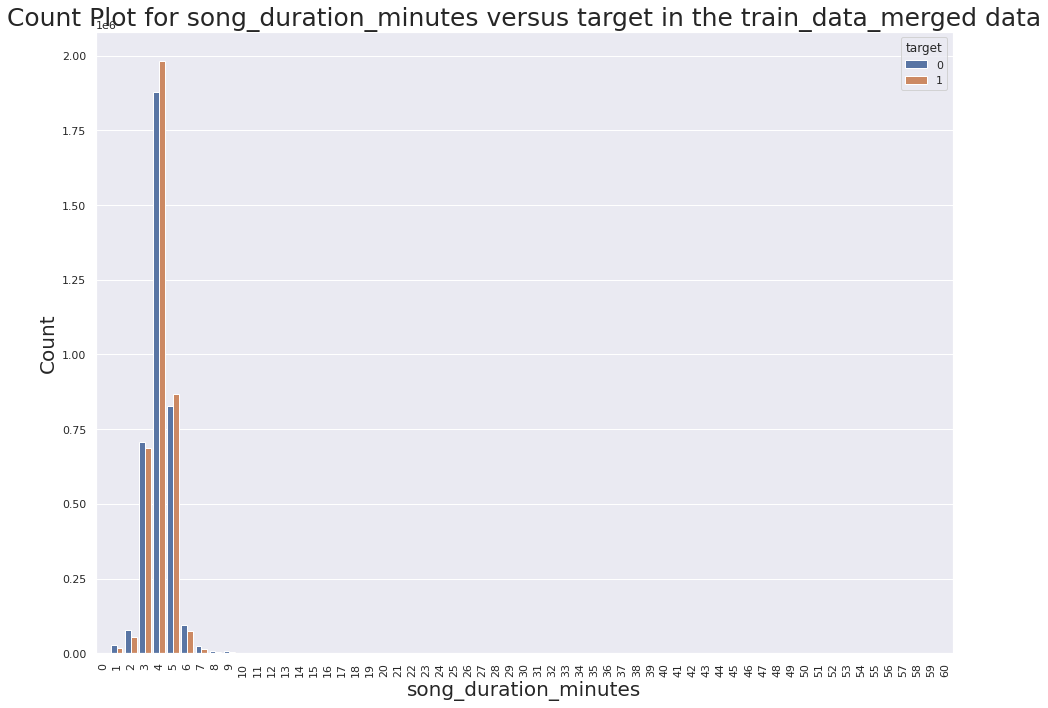

In [ ]:
count_plot(train_data_merged, 'song_duration_minutes', 'target', 'train_data_merged')

It can be seen that most songs are of duration around 4 minutes, and most users prefer listeing to songs with duration close to or around 4 minutes of length. Both target values are in equal number for all songs with different durations.  

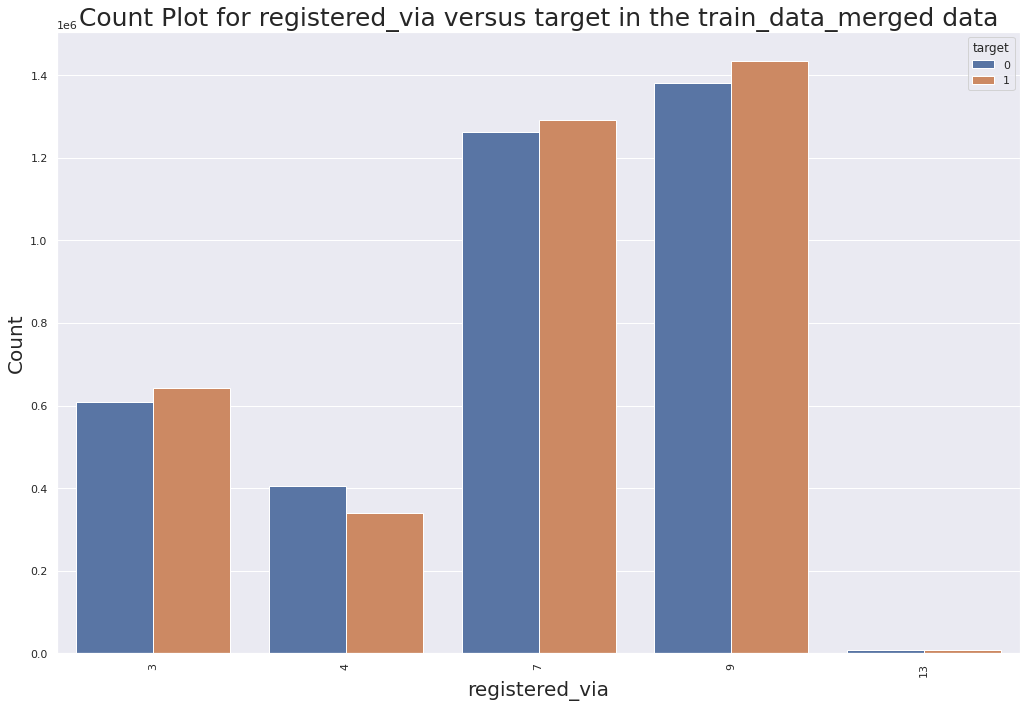

In [ ]:
count_plot(train_data_merged, 'registered_via', 'target', 'train_data_merged')

Most users prefer to register via modes 9 and 7.

In [ ]:
#train_data_merged.registration_init_time = pd.to_datetime(train_data_merged.registration_init_time.astype('str'))
#train_data_merged.expiration_date = pd.to_datetime(train_data_merged.expiration_date.astype('str'))

In [ ]:
time_to_expiration = (train_data_merged.expiration_date -
                      train_data_merged.registration_init_time).astype('timedelta64[h]')/24
                      
time_to_expiration.describe()

count    7.377418e+06
mean     1.627961e+03
std      1.128673e+03
min     -1.619100e+04
25%      7.010000e+02
50%      1.433000e+03
75%      2.286000e+03
max      5.149000e+03
dtype: float64

In [ ]:
train_data_merged['membership_days_left'] = train_data_merged['expiration_date'].subtract(
                                            train_data_merged['registration_init_time']).dt.days.astype(int)

In [ ]:
train_data_merged.genre_ids.unique()

array(['359', '1259', '1019', '1011', '465', '2022', '458', '465|458',
       nan, '1609', '423', '921', '451', '437', '465|1259', '444',
       '921|458', '958', '829', '921|465', '691', '940|388', '880|458',
       '1616|1609', '1616', '139|125|109', '465|430', '1152|829', '139',
       '947', '2157', '940', '726', '786|726', '2122', '458|1287',
       '786|947', '465|1011', '864|850|726|857|843', '786', '786|2122',
       '242|726', '726|242', '352|1995', '444|1259', '698', '465|921',
       '893', '465|139', '2122|947|958', '958|786', '388', '2176|2093',
       '1152', '430', '465|2122', '1155', '1616|2058', '242', '2116|1616',
       '1180', '864|857|850|843', '465|2022', '1609|465', '873',
       '864|786|850|857|843', '1609|458', '864|850|857|921|843', '900',
       '2189|367', '798', '1572|275', '1609|282', '444|1609', '829|786',
       '2086', '545', '437|850', '465|798', '465|958', '864|843', '2079',
       '1605', '465|691', '880', '1955', '1609|2107', '184|2122', '409',
   

In [ ]:
train_data_merged.genre_ids.nunique()

572

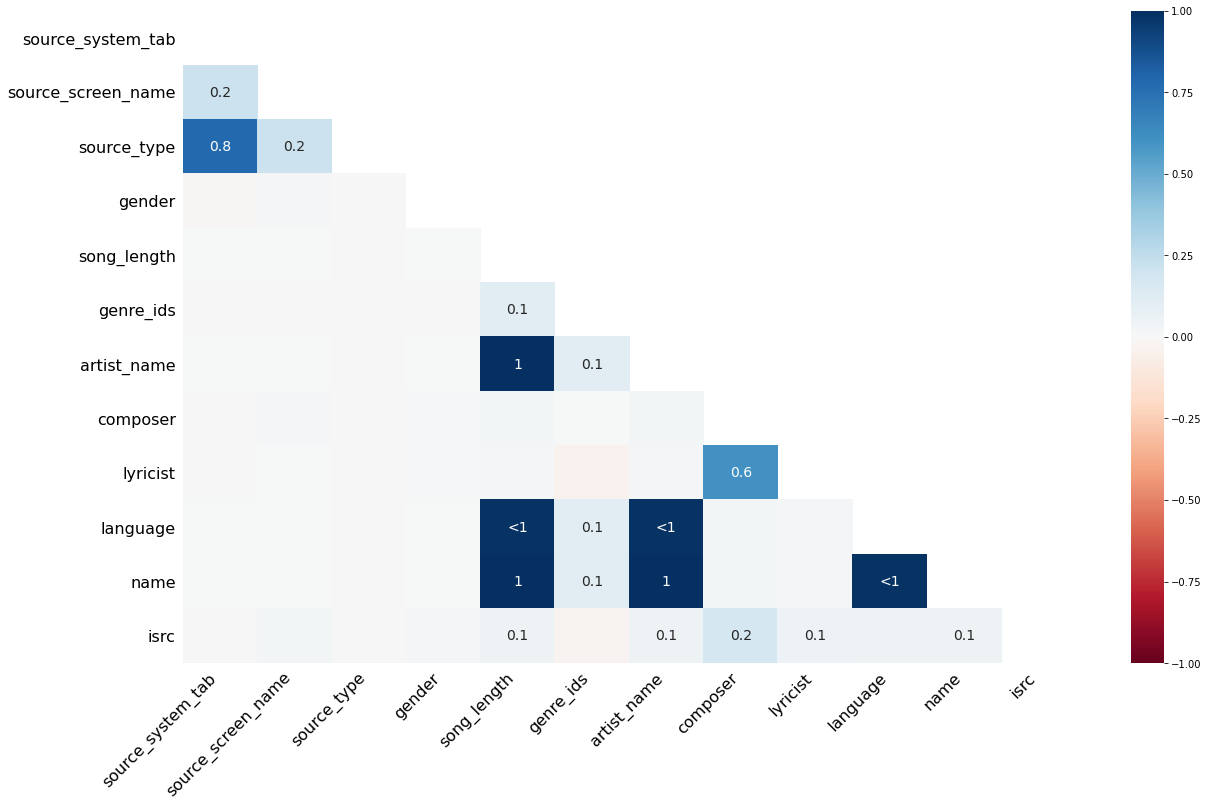

In [ ]:
msno.heatmap(train_data_merged)

Some tabs have a very strong positive correlation between their missing values with some of them being as follows:
1. 'ártist_name' & 'language'
2. 'song_length' & 'language'
3. 'song_length' & 'artist_name'
4. 'composer' & 'lyricist'
5. 'source_system_tab' & 'source_type'

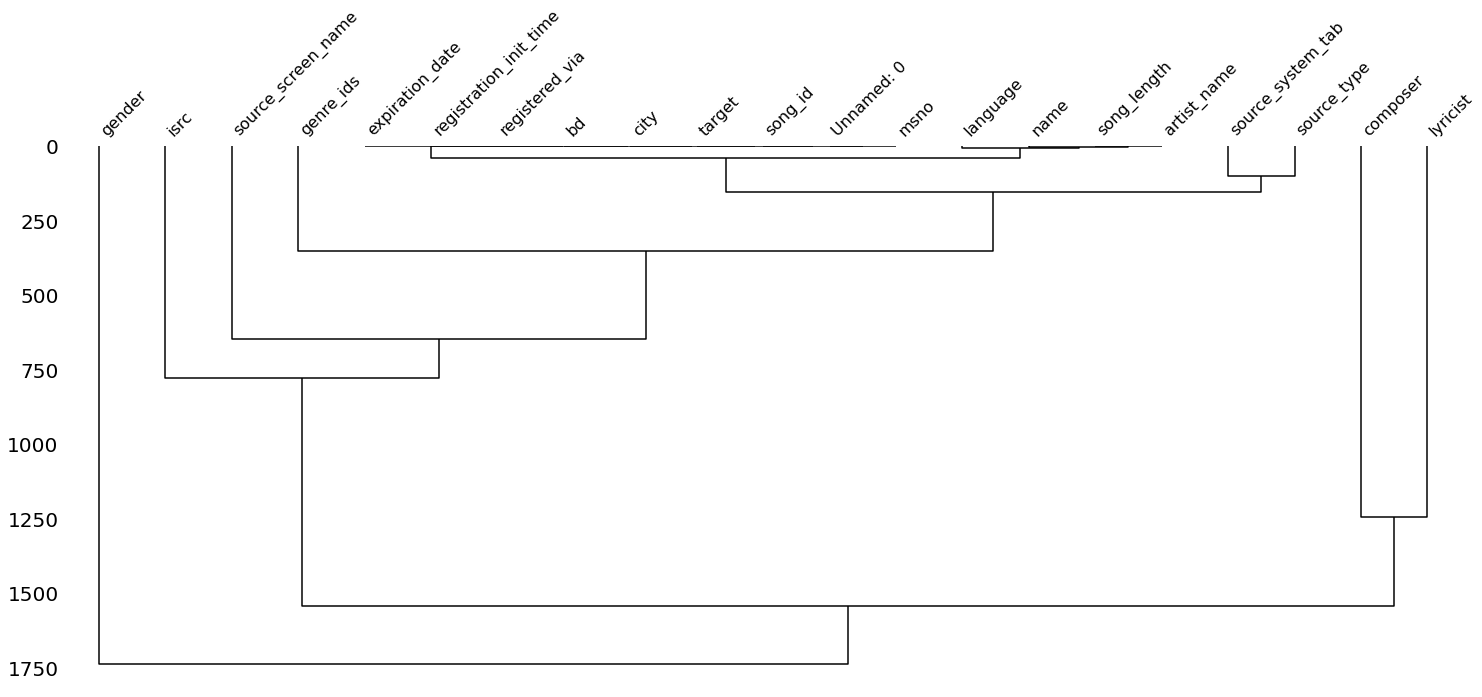

In [ ]:
msno.dendrogram(train_data_merged)

Some tabs have a very strong positive correlation between their missing values with some of them being as follows:
1. 'ártist_name' & 'language'
2. 'song_length' & 'language'
3. 'song_length' & 'artist_name'
4. 'composer' & 'lyricist'
5. 'source_system_tab' & 'source_type'
6. 'expiration_date' & 'registration_init_time'

Attributes which tend to join the last are least correlated.

<h3>3.8 Train & Validation Split<h3>

*Our data is chronologically ordered, thus, we will be implementing Time-Based splitting in 80:20 ratio* 



In [ ]:
split_index = train_data_merged.shape[0] * 8 // 10

train_split = train_data_merged.iloc[:split_index]
val_split = train_data_merged.iloc[split_index:]

In [ ]:
print("Shape of train data after splitting: ", train_split.shape)
print("Shape of validation data after splitting: ", val_split.shape)
print("Shape of test data after splitting: ", test.shape)

Shape of train data after splitting:  (5901934, 22)
Shape of validation data after splitting:  (1475484, 22)
Shape of test data after splitting:  (2556790, 6)


In [ ]:
train_split.to_csv('train_split.csv')
!cp train_split.csv "/content/gdrive/My Drive/Kaggle_KKBoxMusic"

val_split.to_csv('val_split.csv')
!cp val_split.csv "/content/gdrive/My Drive/Kaggle_KKBoxMusic"

cp: 'train_split.csv' and '/content/gdrive/My Drive/Kaggle_KKBoxMusic/train_split.csv' are the same file
cp: 'val_split.csv' and '/content/gdrive/My Drive/Kaggle_KKBoxMusic/val_split.csv' are the same file
